In [148]:
from PID import dxdt, y_f, x_next
from PID import *
import matplotlib.pyplot as plt 
import optuna
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
import numpy as np 
import openpyxl
from openpyxl import Workbook, load_workbook

In [180]:
# Data Loading
print("LOADING DATA")
dataset_train = np.loadtxt("data/PID_data.csv", delimiter=",")
dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=",")

t = dataset_train[:,0]
t2 = dataset_test[:,0]

dt = t[1] - t[0]

dataset_train = dataset_train[:, 1:]
dataset_test = dataset_test[:, 1:]

dataset_train

X_train, Y_train = data_to_X_Y(dataset_train, window_size=3)
X_test, Y_test = data_to_X_Y(dataset_test, window_size=3)

pre = Scaler()
pre.fit(X_train)

filename = "results/GRU/modeling.xlsx"
#wb = Workbook()
#ws = wb.active
#ws.title = "GRU"
#ws.append(["n hidden", "fun1", "window size", "train loss", "val loss", "test loss", "offline loss"])
#wb.save(filename)
#wb.close()

print(pre)

print("DATA LOADED")

LOADING DATA
min_vals:[7.775      0.01620173 6.38545328]
max_vals:[23.325       4.94983813  8.47932079]
DATA LOADED


In [237]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 


        
def data_to_X_Y(data, window_size=2):
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        row = [r for r in data[i:i+window_size]]  
        x.append(row)
        label = data[i+window_size][-1]
        y.append(label)
    return np.array(x), np.array(y)
        
def create_model(params: dict):
    """
    Function that automates the creation of a model based
    on the params input
    """
    
    n = params["nhidden"]
    fun1 = params["activation1"]
    
    model = Sequential()
    model.add(Input((None, 3)))
    model.add(GRU(n,activation=fun1))
    model.add(Dense(1))

    model.compile(
        loss = "mse",
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    )

    return model

def get_offline_error(k, model):
    dt = 0.5
    t_sim = np.arange(0, 100, dt)
    
    X_off = np.zeros((t_sim.shape[0], 2))
    U_off = np.zeros((t_sim.shape[0], 2))
    Y_off = np.zeros(t_sim.shape[0])
    Y_pred = np.zeros(t_sim.shape[0])
    
    X_off[0, :] = [Wa, Wb]
    Y_off[0] = y_f(X_off[0], x0=7.0)
    Y_pred[0] = Y_off[0]
    U_off[:, :] = [u1ss, u2ss]
    
    U_off[20:, 0] *= 1.25
    U_off[100:, 1] *= 20
    
    for n in range(0, t_sim.shape[0] - 1):
        X_off[n + 1, :] = x_next(X_off[n], U_off[n], dt)
        Y_off[n + 1] = y_f(X_off[n + 1], x0=Y_off[n])
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in range(k, t_sim.shape[0] - 1):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0,0])

    score = mse(Y_off, Y_pred)
    return score

def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def tuna_obj(trial):

    # Decision variables
    n = trial.suggest_int('n_hidden', 1, 100)
    fun1 = trial.suggest_categorical("activation function", ["relu", "tanh", "linear"])
    window_size = trial.suggest_int("window_size", 2, 10)
    
    tuna_params = {
        "nhidden": n,
        "activation1": fun1,
        "window_size": window_size,
    }
    
    tuna_model = create_model(tuna_params)

    x_tuna, y_tuna = data_to_X_Y(dataset_train, window_size = window_size)
    x2, y2 = data_to_X_Y(dataset_test, window_size=window_size)
    xN = pre(x_tuna)
    # fit model
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    tuna_model.fit(xN, y_tuna, validation_split=0.25, batch_size=64, epochs=15, callbacks=[callback])
    final_loss = tuna_model.history.history["loss"][-1]
    final_val_loss = tuna_model.history.history["val_loss"][-1]
    test_loss = mse(tuna_model.predict(pre(x2)), y2)
    offline_score = get_offline_error(window_size, tuna_model)
    try:
        wb = load_workbook(filename)
        ws = wb.active
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
    except:
        wb = Workbook()
        ws = wb.active
        ws.title = "GRU"
        ws.append(list(tuna_params.keys()) + ["train loss", "val loss", "test loss", "offline loss"])
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
        

    return offline_score

In [230]:
import pickle 
try:
    with open("tuna_study.obj", "rb") as file:
        study = pickle.load(file)
except:
    study = optuna.create_study()
    
study.optimize(tuna_obj, n_trials=5)

with open("tuna_study.obj", "wb") as file:
    pickle.dump(study, file)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.0129 - val_loss: 0.0043
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

[I 2024-07-22 20:47:28,456] Trial 16 finished with value: 0.12772228343024447 and parameters: {'n_hidden': 87, 'activation function': 'linear', 'window_size': 2}. Best is trial 16 with value: 0.12772228343024447.


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15.5465 - val_loss: 0.0325
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0110 - val_loss: 0.0044
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

[I 2024-07-22 20:47:52,205] Trial 17 finished with value: 1.0724160048388598 and parameters: {'n_hidden': 55, 'activation function': 'linear', 'window_size': 2}. Best is trial 16 with value: 0.12772228343024447.


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 50.5148 - val_loss: 26.7467
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21.6748 - val_loss: 13.1282
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10.8472 - val_loss: 6.5531
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2347 - val_loss: 2.9654
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2703 - val_loss: 1.2030
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8729 - val_loss: 0.4735
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3434 - val_loss: 0.2340
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1948 - val_loss: 0.1735
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1623 - val_loss: 0.1608
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1587 - val_loss: 0.1581
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1583 - val_loss: 0.1569
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

[I 2024-07-22 20:48:16,056] Trial 18 finished with value: 0.8055886116941329 and parameters: {'n_hidden': 2, 'activation function': 'tanh', 'window_size': 3}. Best is trial 16 with value: 0.12772228343024447.


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 15.6962 - val_loss: 0.0054
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

[I 2024-07-22 20:48:48,643] Trial 19 finished with value: 1893.477964682042 and parameters: {'n_hidden': 75, 'activation function': 'relu', 'window_size': 6}. Best is trial 16 with value: 0.12772228343024447.


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.6823 - val_loss: 0.0062
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

[I 2024-07-22 20:49:12,789] Trial 20 finished with value: 861.0291881719514 and parameters: {'n_hidden': 39, 'activation function': 'linear', 'window_size': 3}. Best is trial 16 with value: 0.12772228343024447.


In [231]:
#gru_model = create_model()
best_params = {
        "nhidden": study.best_params["n_hidden"],
        "activation1": study.best_params["activation function"],
        "window_size":  study.best_params["window_size"]
    }

gru_model = create_model(best_params)
x_train, y_train = data_to_X_Y(dataset_train, window_size=best_params["window_size"])
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
gru_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
)
gru_model.fit(pre(x_train), y_train, epochs=100, validation_split=0.25, callbacks=[callback])

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35.0145 - val_loss: 1.6299
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4530 - val_loss: 0.4829
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3397 - val_loss: 0.0399
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0213 - val_loss: 0.0045
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 10/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 11/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 12/100
938/938 ━━━━━━━━━━━━━━━━━━━

In [232]:
gru_model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_35 (GRU)                    │ (None, 87)             │        24,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,302 (282.43 KB)

 Trainable params: 24,100 (94.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,202 (188.29 KB)

In [235]:
def get_offline_error(k, model):
    dt = 0.5
    t_sim = np.arange(0, 100, dt)
    
    X_off = np.zeros((t_sim.shape[0], 2))
    U_off = np.zeros((t_sim.shape[0], 2))
    Y_off = np.zeros(t_sim.shape[0])
    Y_pred = np.zeros(t_sim.shape[0])
    
    X_off[0, :] = [Wa, Wb]
    Y_off[0] = y_f(X_off[0], x0=7.0)
    Y_pred[0] = Y_off[0]
    U_off[:, :] = [u1ss, u2ss]
    
    U_off[20:, 0] *= 1.25
    U_off[100:, 1] *= 20
    
    for n in range(0, t_sim.shape[0] - 1):
        X_off[n + 1, :] = x_next(X_off[n], U_off[n], dt)
        Y_off[n + 1] = y_f(X_off[n + 1], x0=Y_off[n])
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in range(k, t_sim.shape[0] - 1):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0,0])

    score = mse(Y_off, Y_pred)
    return Y_off, Y_pred

(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
(1, 2, 3)


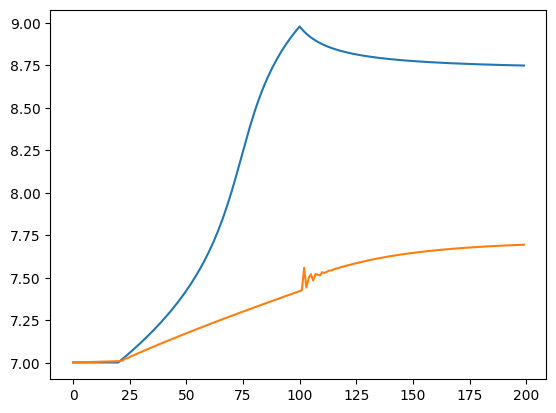

In [236]:
Y_off, Y_pred = get_offline_error(best_params["window_size"], gru_model)
print(mse(Y_off, Y_pred))
plt.plot(Y_off)
plt.plot(Y_pred)